# Bootstrapping Variability into Mass Transport on Decadal Time-Scales

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
from zipfile import ZipFile
import gsw
import pandas as pd
import geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import time
import datetime
from scipy.stats import linregress
from scipy.stats import t
import scipy.stats as stats
import cmocean.cm as cmo
from erddapy import ERDDAP
import matplotlib.gridspec as gridspec
import cartopy
import geopy.distance
from scipy.interpolate import interp1d
import statsmodels.api as sm
from pyproj import Geod
import random


## Functions

In [2]:
def subset(ds,lon_min,lon_max,lat_min,lat_max):
    ## profiles that fulfill the lat/lon ranges
    ind = np.where((ds.LONGITUDE>=lon_min) & (ds.LONGITUDE<=lon_max) &
                   (ds.LATITUDE>=lat_min)  & (ds.LATITUDE<=lat_max))[0]
    ## subset
    subset_ds = xr.merge([ds.PSAL_CORRECTED[ind,:],
                      ds.POTM_CORRECTED[ind,:],
                      ds.DEPH_CORRECTED[ind,:],
                      ds.POSITION_QC[ind],
                      ds.PROFILE_POTM_QC[ind],
                      ds.PROFILE_PSAL_QC[ind],
                      ds.POTM_CORRECTED_QC[ind],
                      ds.PSAL_CORRECTED_QC[ind],
                      ds.INST_REFERENCE[ind],
                      ds.JULD[ind],
                      ds.LONGITUDE[ind],
                      ds.LATITUDE[ind],
                     ],combine_attrs='drop')
    return subset_ds




def qaqc(ds):
    ## Pull out profiles that fail check
    position_qc_ind = np.where(ds.POSITION_QC == b'4')[0]
    profile_potm_qc_ind = np.where(ds.PROFILE_POTM_QC == b'4')[0]
    profile_psal_qc_ind = np.where(ds.PROFILE_PSAL_QC == b'4')[0]
    potm_corrected_qc_ind = np.where(ds.POTM_CORRECTED_QC == b'4')[0]
    psal_corrected_qc_ind = np.where(ds.PSAL_CORRECTED_QC == b'4')[0]
    ## Combine indicies
    tot_qc_ind = np.unique(np.concatenate([position_qc_ind,profile_potm_qc_ind,profile_psal_qc_ind,potm_corrected_qc_ind,psal_corrected_qc_ind]))
    ## Remove from dataset
    ds.PSAL_CORRECTED[tot_qc_ind,:] = np.nan
    ds.POTM_CORRECTED[tot_qc_ind,:] = np.nan
    return ds




def gsw_convert(ds):
    
    lats = np.tile(ds.LATITUDE,(len(ds.N_LEVELS),1)).transpose()
    lons = np.tile(ds.LONGITUDE,(len(ds.N_LEVELS),1)).transpose()
    pressure = gsw.p_from_z(-ds.DEPH_CORRECTED, lats, geo_strf_dyn_height=0, sea_surface_geopotential=0)

    ds['absolute_salinity'] = gsw.SA_from_SP(ds.PSAL_CORRECTED, pressure, lons, lats)    
    ds['conservative_temperature'] = gsw.CT_from_pt(ds.absolute_salinity, ds.POTM_CORRECTED)
    
    return ds





def depth_grid(ds):
    ########################################################################################################################
    #### Depth grid interpolation
    depth_grid = np.concatenate([np.arange(0,101,5),np.arange(125,251,25),np.arange(300,1501,50),np.arange(1550,7000,250)])

    temp_interp = np.empty((len(depth_grid),ds.conservative_temperature.shape[1]))
    salt_interp = np.empty((len(depth_grid),ds.conservative_temperature.shape[1]))
    

    for x in np.arange(0,ds.conservative_temperature.shape[1]):
        temp_interp[:,x] = np.interp(depth_grid, ds.DEPH_CORRECTED.values[:,x], ds.conservative_temperature[:,x], left=np.nan, right=np.nan)
        salt_interp[:,x] = np.interp(depth_grid, ds.DEPH_CORRECTED.values[:,x], ds.absolute_salinity[:,x], left=np.nan, right=np.nan)
    ########################################################################################################################

    ## Check which profiles are NOT all nans
    non_nan_ind = np.where(np.sum(np.isnan(salt_interp),axis=0)!=len(depth_grid))[0]

    new_ds = xr.Dataset(
        data_vars=dict(
            conservative_temperature = (["depth", "time"], temp_interp[:,non_nan_ind]),
            absolute_salinity        = (["depth", "time"], salt_interp[:,non_nan_ind]),
            longitude                = (["time"], ds.LONGITUDE.values[non_nan_ind]),
            latitude                 = (["time"], ds.LATITUDE.values[non_nan_ind]),
            obs_type                 = (["time"], ds.INST_REFERENCE.values[non_nan_ind]))
            ,
        coords=dict(
            depth = depth_grid,
            time  = ds.JULD.values[non_nan_ind]))
    
    new_ds = new_ds.sortby('time')

    return new_ds








def spatial_grid(ds,lon_step,time=None):

    ########################################################################################################################
    #### Spatial grid
    # lon_step = 0.5 # degrees
    # lat_step = 0.5 # degrees

    ## Went larger than shapefile and then clip will trim
    lon_gridt = np.arange(-77.5,-17,lon_step)
    lat_max = 23    # started with 23
    lat_min = 20    # started with 20
    #lat_gridt = np.arange(21,24,lat_step)

    ## Lat/Lon grid mid points
    mid_lons = lon_gridt+(lon_step/2)
    #mid_lats = lat_gridt+(lat_step/2)

    ## For total anomaly
    if time == None:
        ## Preallocate
        grid_temp     = np.empty((len(ds.depth), len(lon_gridt),1))
        grid_temp[:]  = np.nan
        grid_salt     = np.empty((len(ds.depth), len(lon_gridt),1))
        grid_salt[:]  = np.nan
        grid_count    = np.empty(len(lon_gridt),1)
        grid_count[:] = np.nan
        
        ## Stuff data in the grid cells!
        for x in np.arange(0,len(lon_gridt)-1):
            #for y in np.arange(0,len(lat_gridt)-1):
            grid_ind = np.where((ds.longitude.values >= lon_gridt[x])   & 
                                    (ds.longitude.values <= lon_gridt[x+1]) &
                                    (ds.latitude.values  >= lat_min)   &
                                    (ds.latitude.values  <= lat_max))[0]

            grid_temp[:,x,0] = ds.conservative_temperature[:,grid_ind].mean(axis=1)
            grid_salt[:,x,0] = ds.absolute_salinity[:,grid_ind].mean(axis=1)
            grid_count[x,0]  = len(grid_ind)
    
        ### Make a new gridded dataset
        grid_ds = xr.Dataset(
            data_vars=dict(
                conservative_temperature=(["depth", "longitude","latitude"], grid_temp),
                absolute_salinity=(["depth", "longitude","latitude"], grid_salt),
                num_profs = (["latitude","longitude","latitude"],grid_count),
            ),
            coords=dict(
                longitude=mid_lons,
                latitude=np.atleast_1d(21.5),
                depth=ds.depth.values,
            ))
    ## Because adding time dimension
    else:
        # ## Preallocate
        # grid_temp     = np.empty((len(ds.depth), len(lat_gridt), len(lon_gridt),1))
        # grid_temp[:]  = np.nan
        # grid_salt     = np.empty((len(ds.depth), len(lat_gridt), len(lon_gridt),1))
        # grid_salt[:]  = np.nan
        # grid_count    = np.empty((len(lat_gridt), len(lon_gridt),1))
        # grid_count[:] = np.nan
        ## Preallocate
        grid_temp     = np.empty((len(ds.depth), len(lon_gridt),1,1))
        grid_temp[:]  = np.nan
        grid_salt     = np.empty((len(ds.depth), len(lon_gridt),1,1))
        grid_salt[:]  = np.nan
        grid_count    = np.empty((len(lon_gridt),1,1))
        grid_count[:] = np.nan
        
        ## Stuff data in the grid cells!
        for x in np.arange(0,len(lon_gridt)-1):
            grid_ind = np.where((ds.longitude.values >= lon_gridt[x])   & 
                                    (ds.longitude.values <= lon_gridt[x+1]) &
                                    (ds.latitude.values  >= lat_min)   &
                                    (ds.latitude.values  <= lat_max))[0]
                
            grid_temp[:,x,0,0] = ds.conservative_temperature[:,grid_ind].mean(axis=1)
            grid_salt[:,x,0,0] = ds.absolute_salinity[:,grid_ind].mean(axis=1)
            grid_count[x,0,0]  = len(grid_ind)
    
        
        
        ### Make a new gridded dataset
        grid_ds = xr.Dataset(
            data_vars=dict(
                conservative_temperature=(["depth", "longitude","latitude","time"], grid_temp),
                absolute_salinity=(["depth", "longitude","latitude","time"], grid_salt),
                num_profs = (["longitude","latitude","time"],grid_count),
            ),
            coords=dict(
                longitude=mid_lons,
                latitude=np.atleast_1d(21.5),
                depth=ds.depth.values,
                time=np.atleast_1d(pd.to_datetime(time)),
            ))

    return grid_ds




### These were pulled from: https://github.com/KirstieJane/STATISTICS/blob/master/CIs_LinearRegression.py

def lin_fit(x,y):
    '''
    Predicts the values for a best fit between numpy arrays x and y

    Parameters
    ----------
    x: 1D numpy array
    y: 1D numpy array (same length as x)

    Returns
    -------
    p:     parameters for linear fit of x to y
    y_err: 1D array of difference between y and fit values
               (same length as x)

    '''

    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    fit = p(x)

    y_err = y - fit

    return p, y_err

# ----------------------------------------------------------------------------

def conf_calc(x, y_err, c_limit=0.975, test_n=50):
    '''
    Calculates confidence interval of regression between x and y

    Parameters
    ----------
    x:       1D numpy array
    y_err:   1D numpy array of residuals (y - fit)
    c_limit: (optional) float number representing the area to the left
             of the critical value in the t-statistic table
             eg: for a 2 tailed 95% confidence interval (the default)
                    c_limit = 0.975
    test_n:  (optional) integer representing numer of equally-spaced
             x-points to predict in the range min(x) to max(x)

    Returns
    -------
    p_x:   1D array, length "test_n", with values spread evenly between
           min(x) and max(x)
    confs: 1D numpy array of predicted y values for x inputs

    '''
    # Define the variables you need
    # to calculate the confidence interval
    mean_x = np.mean(x)			# mean of x
    n = len(x)				# number of samples in origional fit
    tstat = t.ppf(c_limit, n-1)         # appropriate t value
    s_err = np.sum(np.power(y_err,2))	# sum of the squares of the residuals

    # create series of new test x-values to predict for
    p_x = np.linspace(np.min(x),np.max(x),test_n)

    confs = tstat * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/
			((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))

    return p_x, confs

# ----------------------------------------------------------------------------

def ylines_calc(p_x, confs, fit):
    '''
    Calculates the three lines that will be plotted

    Parameters
    ----------
    p_x:   1D array with values spread evenly between min(x) and max(x)
    confs: 1D array with confidence values for each value of p_x
    fit:   Predicted x -> y function (typically derived from np.poly1d)

    Returns
    -------
    p_y:    1D array with values corresponding to fit line (for p_x values)
    upper:  1D array, values corresponding to upper confidence limit line
    lower:  1D array, values corresponding to lower confidence limit line

    '''
    # now predict y based on test x-values
    p_y = fit(p_x)

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    return p_y, lower, upper

# ----------------------------------------------------------------------------

def plot_linreg_CIs(x, y, p_x, p_y, lower, upper):

    # set-up the plot
    #plt.xlabel('X values')
    #plt.ylabel('Y values')
    #plt.title('Linear regression and confidence limits')

    # plot sample data
    #plt.plot(x, y, 'bo', label='Sample observations')

    # plot line of best fit
    plt.plot(p_x, p_y, 'r-', color='black')

    # plot confidence limits
    plt.plot(p_x, lower, color='grey')
    plt.plot(p_x, upper, color='grey')

    # show the plot
    #plt.show()


def confidence_bounds(x, y, c_limit=0.975, test_n=50):
    '''
    Calculates the predicted (trend) line, and lower & upper confidene bounds
    from original x,y measurements

    Parameters
    ----------
    x: 1D numpy array
    y: 1D numpy array (same length as x)
    c_limit: (optional) float number representing the area to the left
             of the critical value in the t-statistic table
             eg: for a 2 tailed 95% confidence interval (the default)
                    c_limit = 0.975
    test_n:  (optional) integer representing numer of equally-spaced
             x-points to predict in the range min(x) to max(x)

    Returns
    -------
    p_x:    1D array with values spread evenly between min(x) and max(x)
            (length test_n)
    p_y:    1D array with values corresponding to fit line (for p_x values)
            (length test_n)
    upper:  1D array, values corresponding to upper confidence limit line
    lower:  1D array, values corresponding to lower confidence limit line

    '''

    # Fit x to y
    p, y_err = lin_fit(x ,y)

    # Calculate confidence intervals
    p_x, confs = conf_calc(x, y_err, c_limit=c_limit, test_n=test_n)

    # Calculate the lines for plotting:
    # The fit line, and lower and upper confidence bounds
    p_y, lower, upper = ylines_calc(p_x, confs, p)

    return p_x, p_y, lower, upper


geodesic = Geod(ellps="WGS84")  # define the coordinate system. WGS84 is the standard used by GPS.
def calculate_transect(start, end, dist=5000):
    from pyproj import Geod
    g = Geod(ellps="WGS84")
    
    pts = g.inv_intermediate(start[0], start[1], end[0], end[1], 0, dist) 
    _, _, dist = g.inv(np.full(len(pts.lons), start[0]), np.full(len(pts.lons), start[1]), pts.lons, pts.lats)
    return np.column_stack([pts.lons, pts.lats]), dist


def reckon(origin_lon, origin_lat, forward_azimuth, distance):
    """
    Calculate lon, lat of a point from a specified azimuth, distance on sphere or ellipsoid
    Helper function for pyproj.Geod forward transformation

    Args:
        origin_lon (array, numpy.ndarray, list, tuple, or scalar):
            Longitude(s) of initial point(s)
        origin_lat (array, numpy.ndarray, list, tuple, or scalar):
            Latitude(s) of initial point(s)
        forward_azimuth (array, numpy.ndarray, list, tuple, or scalar):
            Azimuth/bearing(s) of the terminus point relative to the initial point(s)
        distance (array, numpy.ndarray, list, tuple, or scalar):
            Distance(s) between initial and terminus point(s) in kilometers

    Returns:
        array, numpy.ndarray, list, tuple, or scalar: Longitude(s) of terminus point(s)
        array, numpy.ndarray, list, tuple, or scalar: Latitude(s) of terminus point(s)
        array, numpy.ndarray, list, tuple, or scalar: Backwards azimuth(s) of terminus point(s)
    """
    terminus_lon, terminus_lat, _ = geodesic.fwd(origin_lon, origin_lat, forward_azimuth, distance * 1000)
    return terminus_lon, terminus_lat

  

## First figure out the clip-zone

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-90.0, -15.0)

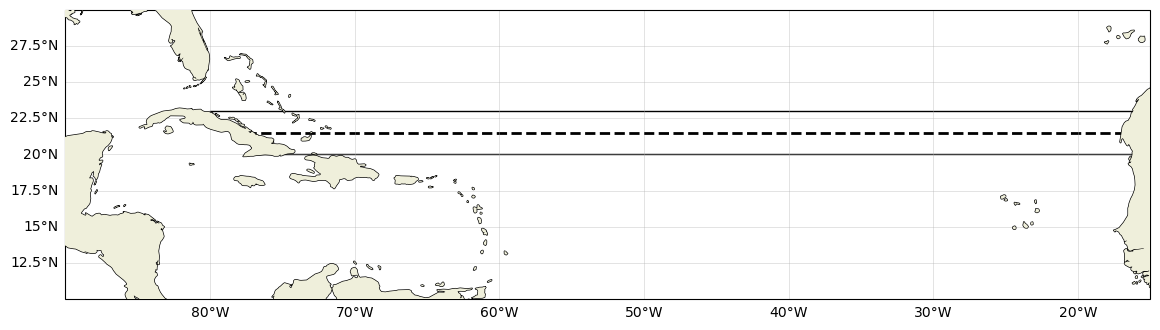

In [3]:
fig, ax = plt.subplots(figsize=(14,12),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

plt.plot([-80, -16], [23, 23],'k', linewidth=1,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [21.5, 21.5],'k--', linewidth=2,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [20, 20],'k', linewidth=1,transform=cartopy.crs.PlateCarree())


ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(10,30)
ax.set_xlim(-90,-15)

# Pre-Processing Step 1:

**This does the following, looping through each file which represents all the data from a month in a year:**
1) Loads data
2) Subsets to box
3) QAQC
4) Depth grid interpolation
5) Save output

This takes ~8 minutes

In [4]:
# # Record the start time
# start_time = time.time()
# print("Start time:", datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'))


# ## Extracted file name
# fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/extracted/*.nc')

# for x in np.arange(0,len(fnames)):
#     ds = xr.open_dataset(fnames[x])

#     subset_ds = subset(ds,lon_min = -79,
#                       lon_max = -16,
#                       lat_min = 21,
#                       lat_max = 23)

#     subset_ds = qaqc(subset_ds)

#     ## Check if there is data after the QAQC
#     if len(subset_ds.N_PROF)==0:
#          continue
#     else:
#         ## Convert to absolute salinity and conservative temperature
#         subset_ds = gsw_convert(subset_ds)
#         ## Transpose to make dimensions make more sense
#         subset_ds = subset_ds.transpose()
#         ## Convert time here
#         subset_ds.JULD.values = pd.to_datetime(subset_ds.JULD)
#         ## Save
#         year = subset_ds.JULD.dt.year.values[0]
#         month = subset_ds.JULD.dt.month.values[0]
#         if len(str(month)) == 1:
#             month = '%02d' % month ## Make 2 digit month if it is only a 1 digit month (i.e. turn 3 into 03 for March)
    
#         ## Do the depth grid interpolation!!
#         subset_ds = depth_grid(subset_ds)   
    
#         ## Save
#         directory_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Processed_ATL/'
#         save_file_name = ''.join([directory_name,"EN4_ATL_",str(year),str(month),".nc"])
#         subset_ds.to_netcdf(save_file_name)
    
    
# # Record the end time
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# # Print the elapsed time in seconds
# print(f"Elapsed time: {elapsed_time} seconds")



# Pre-Processing Step 2:

**This loads the individual months for each year and:**
1) Compute spatial mean
2) Save output

**This takes approximately 30 seconds**

In [5]:
# Record the start time
start_time = time.time()
print("Start time:", datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'))


processed_fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Processed_ATL/*.nc')

for x in np.arange(0,len(processed_fnames)):
    ds1 = xr.open_dataset(processed_fnames[x])
    ds1['time'] = ds1.time.dt.strftime('%Y-%m')
    
    if len(ds1['time'].values) > 0:
        ## spatial mean
        year_ds = spatial_grid(ds1,lon_step=2,time=ds1['time'].values[0])   #### started with 2 deg
        ## Save
        year  = ds1['time'].values[0].split("-")[0]
        month = ds1['time'].values[0].split("-")[1]
        directory_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Monthly_Means_ATL/'
        fname = processed_fnames[x].split("/")[-1].split('.')[0]
        save_file_name = ''.join([directory_name,fname,"_mean.nc"])
        year_ds.to_netcdf(save_file_name)


# Record the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print the elapsed time in seconds
print(f"Elapsed time: {elapsed_time} seconds")


Start time: 2024-07-24 13:48:03
Elapsed time: 14.04304313659668 seconds


# Load!

In [6]:
fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Monthly_Means_ATL/*.nc')

ds = xr.open_mfdataset(fnames,combine='nested', concat_dim='time')
## This is to dask plays nicely
ds = ds.load()
ds = ds.sortby('time')
## Add density
ds['potential_density'] = gsw.sigma0(ds.absolute_salinity, ds.conservative_temperature)+1000

#tot_ds = ds.mean(dim='time')
## Save
#save_file_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/EN4_ATL_Total_Spatial_Mean.nc'
#tot_ds.to_netcdf(save_file_name)

## Climatological spatial mean ds: PRELIMINARY
clim_mean_ds = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/EN4_ATL_Total_Spatial_Mean.nc')
clim_mean_ds['potential_density'] = gsw.sigma0(clim_mean_ds.absolute_salinity, clim_mean_ds.conservative_temperature)+1000
## convert CT and AS to PT and PSU
clim_mean_ds['potential_temp'] = gsw.pt_from_CT(clim_mean_ds.absolute_salinity, clim_mean_ds.conservative_temperature)
clim_mean_ds['practical_salinity'] = gsw.SP_from_SA(clim_mean_ds.absolute_salinity, gsw.p_from_z(-clim_mean_ds.depth,clim_mean_ds.latitude),clim_mean_ds.longitude,clim_mean_ds.latitude)

## Calculate standard deviation at each depth and longitude point
std_ds = ds.std(dim='time').isel(latitude=0)

###############################################################################################################################################
## IMPORT QAQC STEP HERE
###############################################################################################################################################

def filter_based_on_std(data,mean,std):
    ## Calculate the values difference from the mean
    diff_from_mean = np.abs(data - mean)
    ## If it is greater than 1 standard deviation from the mean, set it to nan
    if diff_from_mean > 2*std:
        data = np.nan
    return data


# Apply the function using xarray's apply_ufunc
new_temp = xr.apply_ufunc(
    filter_based_on_std,                     # function to apply
    ds.conservative_temperature,             # argument to pass to the function
    clim_mean_ds.conservative_temperature.mean(dim='longitude'),   # additional argument to pass to the function
    std_ds.conservative_temperature.mean(dim='longitude'),                        # additional argument to pass to the function
    #input_core_dims=[[''], '',''],   # core dimensions for input arrays
    #output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[ds.conservative_temperature.dtype]      # output dtype
)


# Apply the function using xarray's apply_ufunc
new_salt = xr.apply_ufunc(
    filter_based_on_std,                     # function to apply
    ds.absolute_salinity,             # argument to pass to the function
    clim_mean_ds.absolute_salinity.mean(dim='longitude'),   # additional argument to pass to the function
    std_ds.absolute_salinity.mean(dim='longitude'),                        # additional argument to pass to the function
    #input_core_dims=[[''], '',''],   # core dimensions for input arrays
    #output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[ds.absolute_salinity.dtype]      # output dtype
)

## Replace
ds['absolute_salinity'] = new_salt
ds['conservative_temperature'] = new_temp


ds

<xarray.Dataset>
Dimensions:                   (depth: 74, longitude: 31, latitude: 1, time: 570)
Coordinates:
  * longitude                 (longitude) float64 -76.5 -74.5 ... -18.5 -16.5
  * latitude                  (latitude) float64 21.5
  * depth                     (depth) int64 0 5 10 15 20 ... 6050 6300 6550 6800
  * time                      (time) datetime64[ns] 1911-06-01 ... 2023-11-01
Data variables:
    conservative_temperature  (depth, longitude, latitude, time) float64 nan ...
    absolute_salinity         (depth, longitude, latitude, time) float64 nan ...
    num_profs                 (longitude, latitude, time) float64 0.0 ... nan
    potential_density         (depth, longitude, latitude, time) float64 nan ...

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-90.0, -15.0)

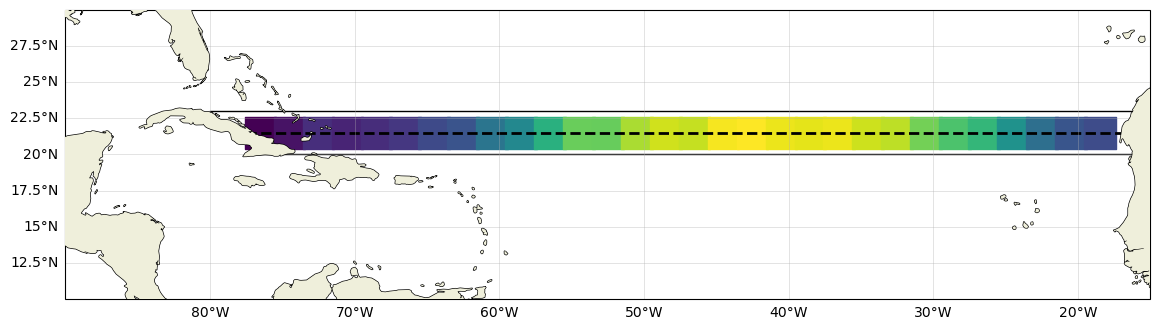

In [7]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(14,12),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

plt.plot([-80, -16], [23, 23],'k', linewidth=1,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [21.5, 21.5],'k--', linewidth=2,transform=cartopy.crs.PlateCarree())
plt.plot([-77.5, -16], [20, 20],'k', linewidth=1,transform=cartopy.crs.PlateCarree())

plt.scatter(ds.longitude,np.repeat(ds.latitude,len(ds.longitude)),c=ds.absolute_salinity.isel(depth=10).mean(dim='time').transpose(),s=520,marker='s',transform=cartopy.crs.PlateCarree())

#ax.add_patch(Rectangle(xy=(ds.longitude[0],ds.latitude,len(ds.longitude))),width=2, height=3,linewidth=1, color=ds.absolute_salinity.isel(depth=10).mean(dim='time').transpose()))

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(10,30)
ax.set_xlim(-90,-15)


## Decadal means

In [8]:
## Remove all-time means first to calculate anomalies
ds['salinity_anomaly'] = ds.absolute_salinity -clim_mean_ds.absolute_salinity
ds['temperature_anomaly'] = ds.conservative_temperature -clim_mean_ds.conservative_temperature
ds['density_anomaly'] = ds.potential_density -clim_mean_ds.potential_density

## Decadal mean since 1960
decadal_ds = ds.copy()
decadal_ds['time'] = (decadal_ds.time.dt.year//10)*10
decadal_ds = decadal_ds.where(decadal_ds.time>=1960,drop=True)
decadal_ds = decadal_ds.groupby(decadal_ds.time).mean()

## Add all-time means back in and replace original variables
decadal_ds['absolute_salinity'] = decadal_ds.salinity_anomaly +clim_mean_ds.absolute_salinity
decadal_ds['conservative_temperature'] = decadal_ds.temperature_anomaly +clim_mean_ds.conservative_temperature
decadal_ds['potential_density'] = decadal_ds.density_anomaly +clim_mean_ds.potential_density

## Delete anomaly variables
decadal_ds = decadal_ds.drop(['salinity_anomaly','temperature_anomaly','density_anomaly'])

## convert CT and AS to PT and PSU
decadal_ds['potential_temp'] = gsw.pt_from_CT(decadal_ds.absolute_salinity, decadal_ds.conservative_temperature)
decadal_ds['practical_salinity'] = gsw.SP_from_SA(decadal_ds.absolute_salinity, gsw.p_from_z(-decadal_ds.depth,decadal_ds.latitude),decadal_ds.longitude,decadal_ds.latitude)

decadal_ds

<xarray.Dataset>
Dimensions:                   (time: 7, depth: 74, longitude: 31, latitude: 1)
Coordinates:
  * longitude                 (longitude) float64 -76.5 -74.5 ... -18.5 -16.5
  * latitude                  (latitude) float64 21.5
  * depth                     (depth) int64 0 5 10 15 20 ... 6050 6300 6550 6800
  * time                      (time) int64 1960 1970 1980 1990 2000 2010 2020
Data variables:
    conservative_temperature  (time, depth, longitude, latitude) float64 26.5...
    absolute_salinity         (time, depth, longitude, latitude) float64 36.8...
    num_profs                 (time, longitude, latitude) float64 0.1 ... nan
    potential_density         (time, depth, longitude, latitude) float64 1.02...
    potential_temp            (time, depth, longitude, latitude) float64 26.5...
    practical_salinity        (time, depth, longitude, latitude) float64 36.6...

## MASK:

Mask based on the all-time mean fields to grab where there is NON-nan data. This way, can look at the decadal means and fill where those are nan with the all-time means.

### Before:

(5000.0, 0.0)

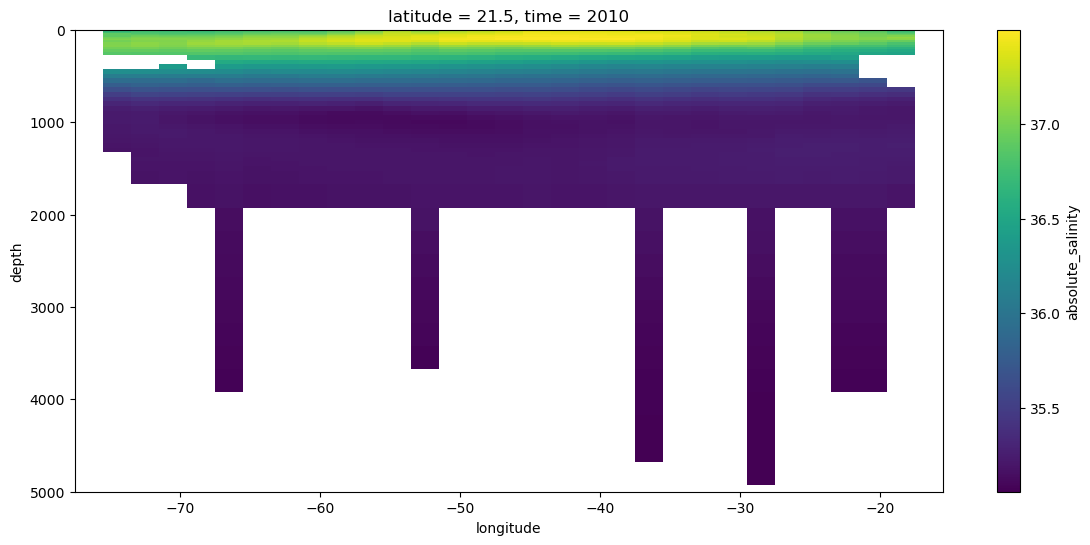

In [9]:
plt.figure(figsize=(14,6))
decadal_ds.absolute_salinity.isel(latitude=0,time=5).plot()
plt.ylim(5000,0)

In [10]:
decadal_ds = decadal_ds.combine_first(clim_mean_ds)
decadal_ds

<xarray.Dataset>
Dimensions:                   (time: 7, depth: 74, longitude: 31, latitude: 1)
Coordinates:
  * longitude                 (longitude) float64 -76.5 -74.5 ... -18.5 -16.5
  * latitude                  (latitude) float64 21.5
  * depth                     (depth) int64 0 5 10 15 20 ... 6050 6300 6550 6800
  * time                      (time) int64 1960 1970 1980 1990 2000 2010 2020
Data variables:
    conservative_temperature  (time, depth, longitude, latitude) float64 26.5...
    absolute_salinity         (time, depth, longitude, latitude) float64 36.8...
    num_profs                 (time, longitude, latitude) float64 0.1 ... nan
    potential_density         (time, depth, longitude, latitude) float64 1.02...
    potential_temp            (time, depth, longitude, latitude) float64 26.5...
    practical_salinity        (time, depth, longitude, latitude) float64 36.6...

## After

(5000.0, 0.0)

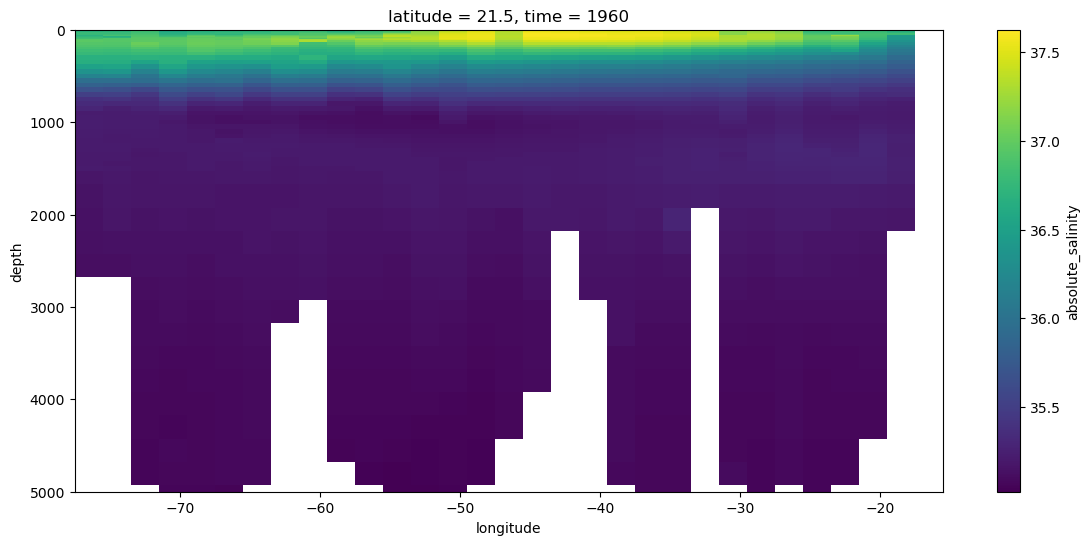

In [11]:
plt.figure(figsize=(14,6))
decadal_ds.absolute_salinity.isel(time=0,latitude=0).plot()
plt.ylim(5000,0)

In [133]:
decadal_ds

<xarray.Dataset>
Dimensions:                   (time: 7, depth: 74, longitude: 31, latitude: 1)
Coordinates:
  * longitude                 (longitude) float64 -76.5 -74.5 ... -18.5 -16.5
  * latitude                  (latitude) float64 21.5
  * depth                     (depth) int64 0 5 10 15 20 ... 6050 6300 6550 6800
  * time                      (time) int64 1960 1970 1980 1990 2000 2010 2020
Data variables:
    conservative_temperature  (time, depth, longitude, latitude) float64 26.5...
    absolute_salinity         (time, depth, longitude, latitude) float64 36.8...
    potential_density         (time, depth, longitude, latitude) float64 1.02...
    potential_temp            (time, depth, longitude, latitude) float64 26.5...
    practical_salinity        (time, depth, longitude, latitude) float64 36.6...

In [ ]:
decadal_slope_ohc[x,y] = linregress(decades[:-1][nanind], decadal_OHC[x,y,nanind])[0]



# dz = 1
# grid_depth = np.arange(0.5, glorys_atl.depth.max().values, dz)

# def depth_interp(old_depth,vel,new_depth):
#     # new_vel = np.empty((len(new_depth),len(glorys_atl.longitude)))
#     # new_vel[:] = np.nan

#     interp_func = interp1d(old_depth, vel, kind='linear')
#     return interp_func(new_depth)

#     # for x in np.arange(0,len(glorys_atl.longitude)):
#     #     interp_func = interp1d(old_depth, vel[:,x], kind='linear')
#     #     new_vel[:,x] = interp_func(new_depth)
#     # return new_vel

# glorys_atl = glorys_atl.chunk({'depth': -1,'longitude': -1,'time':-1})

# # Apply the function using xarray's apply_ufunc
# new_vel = xr.apply_ufunc(
#     depth_interp,                            # function to apply
#     glorys_atl.depth,                           # additional argument to pass to the function
#     glorys_atl.vo.isel(latitude=0),                        # additional argument to pass to the function
#     grid_depth,                              # input array
#     input_core_dims=[['depth'], ['depth'],['new_depth']],  # core dimensions for input arrays
#     output_core_dims=[['new_depth']],            # core dimensions for output array
#     vectorize=True,                          # vectorize the function
#     dask='parallelized',                     # enable parallel computation with dask
#     output_dtypes=[glorys_atl.vo.dtype]      # output dtype
# )
# new_vel

## Load GLORYS velocity fields

In [134]:
fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/*.nc')
glorys = xr.open_mfdataset(fnames,data_vars='minimal',coords='minimal',compat='override',chunks='auto')

## Convert to TEOS-10
pressure = gsw.p_from_z(-glorys.depth,glorys.latitude)
glorys['absolute_salinity'] = gsw.SA_from_SP(glorys.so, pressure, glorys.longitude, glorys.latitude)    
glorys['conservative_temperature'] = gsw.CT_from_pt(glorys.so, glorys.thetao)
glorys['potential_density'] = gsw.sigma0(glorys.absolute_salinity, glorys.conservative_temperature)+1000
## Update attributes
glorys.absolute_salinity.attrs['long_name'] = 'Absolute Salinity'
glorys.absolute_salinity.attrs['unit_long'] = 'Absolute Salinity'
glorys.absolute_salinity.attrs['units'] = 'g kg$^{-1}$'
glorys.conservative_temperature.attrs['long_name'] = 'Conservative Temperature'
glorys.conservative_temperature.attrs['unit_long'] = 'Conservative Temperature'
glorys.conservative_temperature.attrs['units'] = '°C'
glorys.potential_density.attrs['long_name'] = 'Potential Density'
glorys.potential_density.attrs['unit_long'] = 'Potential Density'
glorys.potential_density.attrs['units'] = 'kg m$^{-3}$'

glorys

<xarray.Dataset>
Dimensions:                   (depth: 50, latitude: 265, longitude: 1009,
                               time: 373)
Coordinates:
  * depth                     (depth) float32 0.494 1.541 ... 5.728e+03
  * latitude                  (latitude) float32 8.0 8.083 8.167 ... 29.92 30.0
  * longitude                 (longitude) float32 -98.0 -97.92 ... -14.08 -14.0
  * time                      (time) datetime64[ns] 1993-01-01 ... 2023-12-01
Data variables:
    so                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    thetao                    (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    uo                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    vo                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    absolute_salinity         (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    conservative_temperature  (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
    potential_density         (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 181, 699), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...

## Create greater Atlantic slice

In [135]:
#glorys_atl = glorys.where((glorys.latitude==21.5) & (glorys.longitude>=-77.5),drop=True).mean(dim='time')
glorys_atl = glorys.where((glorys.latitude==21.5) & (glorys.longitude>=-77.5),drop=True)
glorys_atl

<xarray.Dataset>
Dimensions:                   (time: 373, depth: 50, latitude: 1, longitude: 763)
Coordinates:
  * depth                     (depth) float32 0.494 1.541 ... 5.728e+03
  * latitude                  (latitude) float32 21.5
  * longitude                 (longitude) float32 -77.5 -77.42 ... -14.08 -14.0
  * time                      (time) datetime64[ns] 1993-01-01 ... 2023-12-01
Data variables:
    so                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    thetao                    (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    uo                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    vo                        (time, depth, latitude, longitude) float32 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    absolute_salinity         (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    conservative_temperature  (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
    potential_density         (time, depth, latitude, longitude) float64 dask.array<chunksize=(8, 33, 1, 453), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...

In [136]:
# plt.figure(figsize=(14,6))
# glorys_atl.vo.isel(latitude=0).mean(dim='time').plot()
# plt.ylim(5500,0)
# #plt.xlim(-80,-65)
# #plt.xlim(-30,-10)

## Interpolate onto EN4 longitude grid

In [137]:
# dz = 1
# grid_depth = np.arange(0.5, glorys_atl.depth.max().values, dz)

# def depth_interp(old_depth,vel,new_depth):
#     # new_vel = np.empty((len(new_depth),len(glorys_atl.longitude)))
#     # new_vel[:] = np.nan

#     interp_func = interp1d(old_depth, vel, kind='linear')
#     return interp_func(new_depth)

#     # for x in np.arange(0,len(glorys_atl.longitude)):
#     #     interp_func = interp1d(old_depth, vel[:,x], kind='linear')
#     #     new_vel[:,x] = interp_func(new_depth)
#     # return new_vel

# glorys_atl = glorys_atl.chunk({'depth': -1,'longitude': -1,'time':-1})

# # Apply the function using xarray's apply_ufunc
# new_vel = xr.apply_ufunc(
#     depth_interp,                            # function to apply
#     glorys_atl.depth,                           # additional argument to pass to the function
#     glorys_atl.vo.isel(latitude=0),                        # additional argument to pass to the function
#     grid_depth,                              # input array
#     input_core_dims=[['depth'], ['depth'],['new_depth']],  # core dimensions for input arrays
#     output_core_dims=[['new_depth']],            # core dimensions for output array
#     vectorize=True,                          # vectorize the function
#     dask='parallelized',                     # enable parallel computation with dask
#     output_dtypes=[glorys_atl.vo.dtype]      # output dtype
# )
# new_vel

## Make new xr dataset with this array for saving

In [138]:
# # Create the xarray dataset
# glorys_atl_vo_interp_ds = xr.Dataset(
#     {
#         "vvel": (["time","longitude", "depth"], new_vel.values)
#     },
#     coords={
#         "time": glorys_atl.time.values,
#         "longitude": glorys_atl.longitude.values,
#         "depth": grid_depth.flatten(),
#         "latitude":np.atleast_1d(21.0),
#     },
# )
# glorys_atl_vo_interp_ds

In [139]:
# glorys_atl_vo_interp_ds.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_21_5N_1m_dz_vvel_interp_time_series.nc')

## Reload

In [140]:
glorys_atl_vo_interp_ds = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_21_5N_1m_dz_vvel_interp_time_series.nc')
glorys_atl_vo_interp_ds

<xarray.Dataset>
Dimensions:    (time: 373, longitude: 763, depth: 5728, latitude: 1)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2023-12-01
  * longitude  (longitude) float32 -77.5 -77.42 -77.33 ... -14.17 -14.08 -14.0
  * depth      (depth) float64 0.5 1.5 2.5 3.5 ... 5.726e+03 5.726e+03 5.728e+03
  * latitude   (latitude) float64 21.0
Data variables:
    vvel       (time, longitude, depth) float32 ...

## Transport per unit depth

In [141]:
dx = geopy.distance.geodesic([glorys_atl.longitude.values[0],glorys_atl.latitude.values[0]], [glorys_atl.longitude.values[1],glorys_atl.latitude.values[0]]).m
atl_transport_per_unit_depth = (glorys_atl_vo_interp_ds.vvel*dx).sum(dim=['longitude']).mean(dim='time')
atl_transport_per_unit_depth.sum()/(10**6)

<xarray.DataArray 'vvel' ()>
array(-29.196854)

## Put on same grid

In [143]:
decadal_mean_ds_atl = decadal_ds.interp_like(glorys_atl_vo_interp_ds.mean(dim=['time']))
decadal_mean_ds_atl = decadal_mean_ds_atl.rename({'time':'decade'})
decadal_mean_ds_atl = decadal_mean_ds_atl.isel(latitude=0)
decadal_mean_ds_atl.absolute_salinity.isel(decade=0,latitude=0).plot()

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


ValueError: Dimensions {'latitude'} do not exist. Expected one or more of ('decade', 'depth', 'longitude')

## Yucatan Straits Transport

In [144]:
yucatan_pt1 = [-86.742, 21.1256]
yucatan_pt2 = [-84.9348, 21.837]

yucatan_dx = 9000

pts, dist = calculate_transect(yucatan_pt1, yucatan_pt2, yucatan_dx) # 9km spacing to ~match the 1/12 deg GLORYS resolution

glorys_rn = glorys.rename({'longitude': 'x','latitude': 'y'})


# Interpolate Copernicus Transect
yucatan = glorys_rn.interp(
    x=xr.DataArray(pts[:,0], dims="point"),
    y=xr.DataArray(pts[:,1], dims="point"),
)

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/pyproj/geod.py:681: UserWarning: Back azimuth is being returned by default to be compatible with fwd()This is a breaking change for pyproj 3.5+.To avoid this warning, set return_back_azimuth=True.Otherwise, to restore old behaviour, set return_back_azimuth=False.This warning will be removed in future version.
  warnings.warn(


/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-95.0, -70.0)

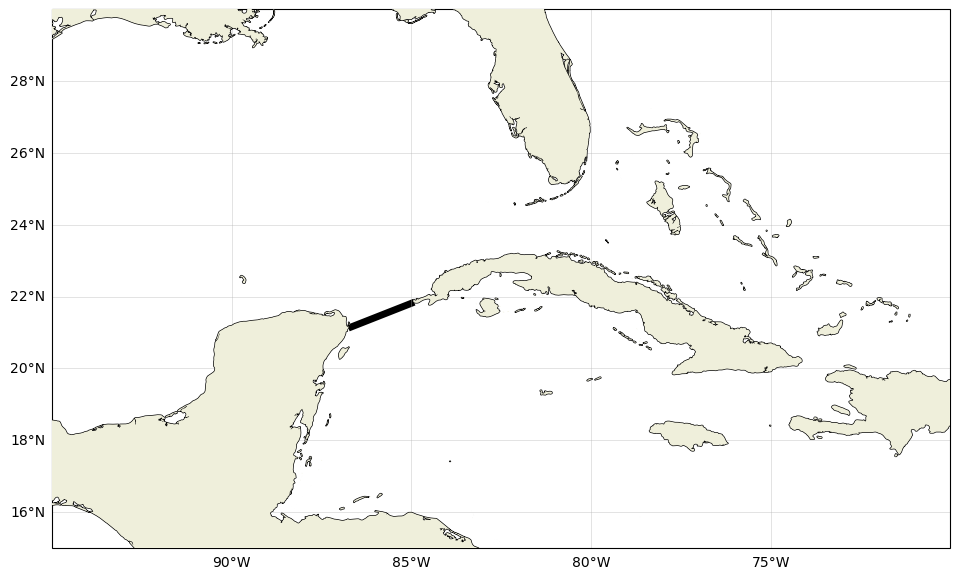

In [145]:
fig, ax = plt.subplots(figsize=(14,7),subplot_kw=dict(projection=cartopy.crs.PlateCarree()))

plt.plot([yucatan.x[-1], yucatan.x[0]], [yucatan.y[-1], yucatan.y[0]],'k', linewidth=5,transform=cartopy.crs.PlateCarree())

ax.coastlines(linewidth=1.0,zorder=10)
ax.add_feature(cartopy.feature.LAND,zorder=10)
glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
ax.set_ylim(15,30)
ax.set_xlim(-95,-70)

## Interp onto regular depth grid to make the transport calculations smoother

In [147]:
dz = 1
grid_depth = np.arange(0.5, np.nanmax(yucatan.depth.values), dz)


yucatan = yucatan.chunk({'time': -1, 'depth':-1})



# Define a function that applies np.gradient along the depth dimension
def interp_along_depth(depth, var, grid_depth):
    interp_func = interp1d(depth, var, kind='linear',fill_value=np.nan,bounds_error=False)
    return interp_func(grid_depth)


# Use xarray's apply_ufunc to interpolate along the depth dimension
yucatan_uvel_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    yucatan['depth'],            # depth array
    yucatan['uo'],        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[yucatan.uo.dtype]     # output dtype
)

# Use xarray's apply_ufunc to interpolate along the depth dimension
yucatan_vvel_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    yucatan['depth'],            # depth array
    yucatan['vo'],        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[yucatan.uo.dtype]     # output dtype
)


# Use xarray's apply_ufunc to interpolate along the depth dimension
yucatan_absolute_salinity_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    yucatan['depth'],            # depth array
    yucatan['absolute_salinity'],        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[yucatan.uo.dtype]     # output dtype
)


# Use xarray's apply_ufunc to interpolate along the depth dimension
yucatan_conservative_temperature_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    yucatan['depth'],            # depth array
    yucatan['conservative_temperature'],        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[yucatan.uo.dtype]     # output dtype
)


# Use xarray's apply_ufunc to interpolate along the depth dimension
yucatan_potential_density_interp = xr.apply_ufunc(
    interp_along_depth,          # function to apply
    yucatan['depth'],            # depth array
    yucatan['potential_density'],        # cross_vel array
    grid_depth,                  # additional argument: new depth levels
    input_core_dims=[['depth'], ['time', 'point', 'depth'], ['grid_depth']],  # specify input dimensions
    output_core_dims=[['time', 'point', 'grid_depth']],           # specify output dimension
    vectorize=True,              # vectorize the function
    dask='parallelized',         # enable parallel computation with dask
    output_dtypes=[yucatan.uo.dtype]     # output dtype
)


In [ ]:
# # Create a new xarray Dataset with the interpolated data
# yucatan_interp = xr.Dataset(
#     {
#         'conservative_temperature': (['time', 'point', 'depth'], yucatan_conservative_temperature_interp.values),
#         'absolute_salinity': (['time', 'point', 'depth'], yucatan_absolute_salinity_interp.values),
#         'potential_density': (['time', 'point', 'depth'], yucatan_potential_density_interp.values),
#         'uvel': (['time', 'point', 'depth'], yucatan_uvel_interp.values),
#         'vvel': (['time', 'point', 'depth'], yucatan_vvel_interp.values),        
#     },
#     coords={
#         'time': yucatan.time.values,
#         'point': yucatan.point.values,
#         'depth': grid_depth  # Use grid_depth as the new depth dimension
#     }
# )
# yucatan_interp

## Save

In [ ]:
# yucatan_interp.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_Yucatan_Straits_Interp.nc')

## Reload

In [ ]:
# yucatan_interp = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_Yucatan_Straits_Interp.nc')
# yucatan_interp

In [ ]:
# yucatan_transport_per_unit_depth = (yucatan_interp.vvel*yucatan_dx).sum(dim=['point']).mean(dim='time')
# yucatan_transport_per_unit_depth.sum()/(10**6)

In [ ]:
# ## Find the area of the greater Atlantic that is not nan
# atl_finite_depths = np.sum((np.isfinite(glorys_atl_vo_interp_ds.mean(dim='time').vvel).values==True),axis=0)
# atl_area = np.sum(atl_finite_depths*dx)

# Can decadal variability in the mass transports be bootstrapped?

##### Approach is to use the transport standard deviation over the 30 year reanalysis and bootstrap, say 1,000 simulations, where I randomly adjust velocity to vary the transport. Then, use these simulated transports as the variability to seem if there is a meaningful trend in tracer transport


In [32]:
# yucatan_trsp_mean = (yucatan_interp.vvel*yucatan_dx).sum(dim=['point','depth']).mean()
# yucatan_trsp_std  = (yucatan_interp.vvel*yucatan_dx).sum(dim=['point','depth']).std()

# atl_trsp_mean = (glorys_atl_vo_interp_ds.vvel*dx).sum(dim=['longitude','depth']).mean(dim='time')
# atl_trsp_std  = (glorys_atl_vo_interp_ds.vvel*dx).sum(dim=['longitude','depth']).std(dim='time')

# print('Yucatan Transport Mean: '+str(np.round(yucatan_trsp_mean.values/(10**6),2))+' ± '+str(np.round(yucatan_trsp_std.values/(10**6),2))+' Sv')
# print('ATL Interior Transport Mean: '+str(np.round(atl_trsp_mean.values/(10**6),2))+' ± '+str(np.round(atl_trsp_std.values/(10**6),2))+' Sv')


In [33]:
# ## determined that depth > 1942 is where there are only nans, due to resolution of GLORYS past this depth
# #yucatan_interp.vvel.where(yucatan_interp.depth<1942,drop=True)
# #yucatan_area = yucatan_dx*1942*22
# yucatan_finite_depths = np.sum((np.isfinite(yucatan_interp.mean(dim='time').vvel).values==True),axis=0)
# yucatan_area = np.sum(yucatan_finite_depths*yucatan_dx)

In [34]:
# print('Yucatan velocity adjustment in the range of ± '+str(np.round((yucatan_trsp_std/yucatan_area).values*100,2))+' cm/s based on the Yucatan transport STD')
# print('ATL interior velocity adjustment in the range of ± '+str(np.round((yucatan_trsp_std/atl_area).values*100,2))+' cm/s based on the Yucatan transport STD')
# print('')
# print('Yucatan velocity adjustment in the range of ± '+str(np.round((atl_trsp_std/yucatan_area).values*100,2))+' cm/s based on the ATL interior transport STD')
# print('ATL interior velocity adjustment in the range of ± '+str(np.round((atl_trsp_std/atl_area).values*100,2))+' cm/s based on the ATL interior transport STD')

## Use the standard deviation in the Yucatan transport, will produce larger error bars

In [35]:
# ## Take all time mean velocity sections to vary
# mean_yucatan_vvel = yucatan_interp.vvel.where(np.isfinite(yucatan_interp.vvel),drop=True).mean(dim='time')
# mean_atl_vvel = glorys_atl_vo_interp_ds.vvel.where(np.isfinite(glorys_atl_vo_interp_ds.vvel),drop=True).mean(dim='time')

# ## Adjust mean fields to be in mass balance before the simulation adjustments
# trsp_diff = (mean_yucatan_vvel*yucatan_dx).sum() + (mean_atl_vvel*dx).sum()
# atl_adjustment = -trsp_diff/atl_area
# mean_atl_vvel = mean_atl_vvel.where(np.isfinite(mean_atl_vvel))+atl_adjustment
# trsp_diff = (mean_yucatan_vvel*yucatan_dx).sum() + (mean_atl_vvel*dx).sum()
# print('Transport difference after adjustment: '+str(trsp_diff.values/(10**6))+' Sv')

## This loop takes ~1 hour

In [36]:
# %%time
# def random_transport_between_neg_and_pos_input(x):
#     return random.uniform(-x, x)


# #simulation = np.arange(1960,2024,1)

# # Generate the time range
# time_range = pd.date_range(start='1960-01', end='2023-12', freq='MS')  ## Results in 753 "months" of transport

# ## Pick a random transport value between +/- the transport standard deviation
# simulation_transport_adjustment = random_transport_between_neg_and_pos_input(yucatan_trsp_std.values)

# ## Calculate the velocity adjustment based on this transport
# yucatan_vel_adjustment = simulation_transport_adjustment/yucatan_area
# atl_vel_adjustment = -simulation_transport_adjustment/atl_area

# ## Adjust
# adjusted_yucatan_vvel = mean_yucatan_vvel.where(np.isfinite(mean_yucatan_vvel)) + yucatan_vel_adjustment
# adjusted_atl_vvel = mean_atl_vvel.where(np.isfinite(mean_atl_vvel)) + atl_vel_adjustment
# ## Transport per unit depth
# adjusted_yucatan_transport_per_unit_depth = adjusted_yucatan_vvel*yucatan_dx
# adjusted_atl_transport_per_unit_depth = adjusted_atl_vvel*dx


# for x in np.arange(1,len(time_range)):
#     ## Pick a random transport value between +/- the transport standard deviation
#     simulation_transport_adjustment = random_transport_between_neg_and_pos_input(yucatan_trsp_std.values)
    
#     ## Calculate the velocity adjustment based on this transport
#     yucatan_vel_adjustment = simulation_transport_adjustment/yucatan_area
#     atl_vel_adjustment = -simulation_transport_adjustment/atl_area
    
#     ## Adjust
#     adjusted_yucatan_vvel = mean_yucatan_vvel.where(np.isfinite(mean_yucatan_vvel)) + yucatan_vel_adjustment
#     adjusted_atl_vvel = mean_atl_vvel.where(np.isfinite(mean_atl_vvel)) + atl_vel_adjustment
#     ## Transport per unit depth
#     adjusted_yucatan_transport_per_unit_depth_temp = adjusted_yucatan_vvel*yucatan_dx
#     adjusted_atl_transport_per_unit_depth_temp = adjusted_atl_vvel*dx
#     ## Stuff in a xr dataset
#     adjusted_yucatan_transport_per_unit_depth = xr.concat([adjusted_yucatan_transport_per_unit_depth, adjusted_yucatan_transport_per_unit_depth_temp], dim='time')
#     adjusted_atl_transport_per_unit_depth = xr.concat([adjusted_atl_transport_per_unit_depth, adjusted_atl_transport_per_unit_depth_temp], dim='time')
#     #print('x '+str(x)+' out of '+str(len(time_range)))

# ## At the end add the simulation coordinate values in
# adjusted_yucatan_transport_per_unit_depth = adjusted_yucatan_transport_per_unit_depth.assign_coords(time=time_range)
# adjusted_atl_transport_per_unit_depth = adjusted_atl_transport_per_unit_depth.assign_coords(time=time_range)


In [37]:
# ## Change time to decade
# adjusted_yucatan_transport_per_unit_depth['time'] = (adjusted_yucatan_transport_per_unit_depth.time.dt.year//10)*10
# adjusted_atl_transport_per_unit_depth['time'] = (adjusted_atl_transport_per_unit_depth.time.dt.year//10)*10

# adjusted_yucatan_transport_per_unit_depth = adjusted_yucatan_transport_per_unit_depth.rename({'time':'decade'})
# adjusted_atl_transport_per_unit_depth = adjusted_atl_transport_per_unit_depth.rename({'time':'decade'})

In [38]:
# ## Repackage for saving
# simulated_decadal_mean_yucatan_transport_vals = adjusted_yucatan_transport_per_unit_depth.groupby(adjusted_yucatan_transport_per_unit_depth.decade).mean()
# simulated_decadal_mean_yucatan_transport_std = adjusted_yucatan_transport_per_unit_depth.groupby(adjusted_yucatan_transport_per_unit_depth.decade).std()

# # Create the xarray Dataset
# simulated_decadal_mean_yucatan_transport = xr.Dataset(
#     {
#         "transport": (["decade", "point", "depth"], simulated_decadal_mean_yucatan_transport_vals.values),
#         "std": (["decade", "point", "depth"], simulated_decadal_mean_yucatan_transport_std.values)
#     },
#     coords={
#         "decade": simulated_decadal_mean_yucatan_transport_vals.decade.values,
#         "point": simulated_decadal_mean_yucatan_transport_vals.point.values,
#         "depth": simulated_decadal_mean_yucatan_transport_vals.depth.values
#     }
# )

# simulated_decadal_mean_yucatan_transport

In [39]:
# ## Repackage for saving
# simulated_decadal_mean_atl_transport_vals = adjusted_atl_transport_per_unit_depth.groupby(adjusted_atl_transport_per_unit_depth.decade).mean()
# simulated_decadal_mean_atl_transport_std = adjusted_atl_transport_per_unit_depth.groupby(adjusted_atl_transport_per_unit_depth.decade).std()

# # Create the xarray Dataset
# simulated_decadal_mean_atl_transport = xr.Dataset(
#     {
#         "transport": (["decade", "longitude", "depth"], simulated_decadal_mean_atl_transport_vals.values),
#         "std": (["decade", "longitude", "depth"], simulated_decadal_mean_atl_transport_std.values)
#     },
#     coords={
#         "decade": simulated_decadal_mean_atl_transport_vals.decade.values,
#         "longitude": simulated_decadal_mean_atl_transport_vals.longitude.values,
#         "depth": simulated_decadal_mean_atl_transport_vals.depth.values
#     }
# )

# simulated_decadal_mean_atl_transport

In [40]:
# simulated_decadal_mean_yucatan_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_Yucatan_Simulated_Decadal_Mean_Transport_per_unit_depth.nc')

In [41]:
# simulated_decadal_mean_atl_transport.to_netcdf('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_ATL_Simulated_Decadal_Mean_Transport_per_unit_depth.nc')

## Reload

In [46]:
simulated_decadal_mean_yucatan_transport = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_Yucatan_Simulated_Decadal_Mean_Transport_per_unit_depth.nc')
simulated_decadal_mean_yucatan_transport = simulated_decadal_mean_yucatan_transport.sum(dim='point')
simulated_decadal_mean_yucatan_transport

<xarray.Dataset>
Dimensions:    (decade: 7, depth: 1942)
Coordinates:
  * decade     (decade) int64 1960 1970 1980 1990 2000 2010 2020
  * depth      (depth) float64 0.5 1.5 2.5 3.5 ... 1.94e+03 1.94e+03 1.942e+03
Data variables:
    transport  (decade, depth) float64 1.08e+05 1.079e+05 ... 323.4 323.9
    std        (decade, depth) float64 2.226e+03 2.226e+03 ... 104.1 104.1

In [47]:
simulated_decadal_mean_atl_transport = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/GLORYS/Sections/GLORYS_ATL_Simulated_Decadal_Mean_Transport_per_unit_depth.nc')
simulated_decadal_mean_atl_transport

<xarray.Dataset>
Dimensions:    (decade: 7, longitude: 719, depth: 5275)
Coordinates:
  * decade     (decade) int64 1960 1970 1980 1990 2000 2010 2020
  * longitude  (longitude) float32 -76.92 -76.83 -76.75 ... -17.17 -17.08 -17.0
  * depth      (depth) float64 0.5 1.5 2.5 3.5 ... 5.272e+03 5.274e+03 5.274e+03
Data variables:
    transport  (decade, longitude, depth) float64 ...
    std        (decade, longitude, depth) float64 ...

## Now can do the tracer transports!

Text(0, 0.5, 'Transport [Sv]')

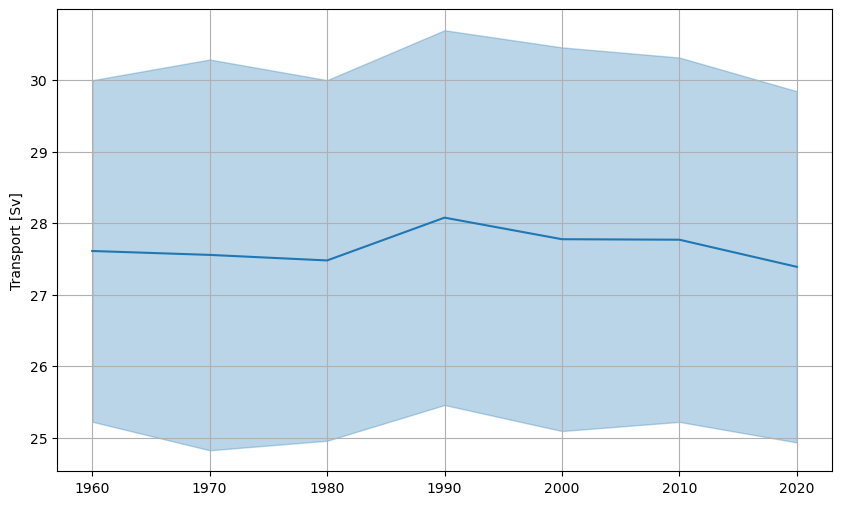

In [43]:
plt.figure(figsize=(10,6))
plt.plot(simulated_decadal_mean_yucatan_transport.decade,simulated_decadal_mean_yucatan_transport.transport.sum(dim=['point','depth'])/(10**6),color='tab:blue')
plt.fill_between(simulated_decadal_mean_yucatan_transport.decade, (simulated_decadal_mean_yucatan_transport.transport.sum(dim=['point','depth'])-simulated_decadal_mean_yucatan_transport['std'].sum(dim=['point','depth']))/(10**6),
                (simulated_decadal_mean_yucatan_transport.transport.sum(dim=['point','depth'])+simulated_decadal_mean_yucatan_transport['std'].sum(dim=['point','depth']))/(10**6),color='tab:blue',alpha=0.3)

plt.grid()
plt.ylabel('Transport [Sv]')

## Load Caribbean decadal means

In [150]:
decadal_mean_ds_ctf = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/EN4_CTF_1960_2020_Mean_Decadal_Profiles_Trends.nc')

## Make same depth as the transport ds
dz = 1
grid_depth = np.arange(0.5, glorys_atl.depth.max().values, dz)

def depth_interp(old_depth,vel,new_depth):
    interp_func = interp1d(old_depth, vel, kind='linear')
    return interp_func(new_depth)


# Apply the function using xarray's apply_ufunc
decadal_mean_ds_ctf = xr.apply_ufunc(
    depth_interp,                            # function to apply
    decadal_mean_ds_ctf.depth,                           # additional argument to pass to the function
    decadal_mean_ds_ctf,                        # additional argument to pass to the function
    grid_depth,                              # input array
    input_core_dims=[['depth'], ['depth'],['new_depth']],  # core dimensions for input arrays
    output_core_dims=[['new_depth']],            # core dimensions for output array
    vectorize=True,                          # vectorize the function
    dask='parallelized',                     # enable parallel computation with dask
    output_dtypes=[glorys_atl.vo.dtype]      # output dtype
)

decadal_mean_ds_ctf = decadal_mean_ds_ctf.rename({'new_depth':'depth'})
decadal_mean_ds_ctf['depth'] = grid_depth

## convert CT and AS to PT and PSU
# decadal_mean_ds_ctf['potential_temp'] = gsw.pt_from_CT(decadal_mean_ds_ctf.salt, decadal_mean_ds_ctf.temp)
# decadal_mean_ds_ctf['practical_salinity'] = gsw.SP_from_SA(decadal_mean_ds_ctf.salt, gsw.p_from_z(-decadal_mean_ds_ctf.depth,15),-70,15)
decadal_mean_ds_ctf = decadal_mean_ds_ctf.transpose()
decadal_mean_ds_ctf

<xarray.Dataset>
Dimensions:     (decade: 7, depth: 5728)
Coordinates:
  * decade      (decade) int64 1960 1970 1980 1990 2000 2010 2020
  * depth       (depth) float64 0.5 1.5 2.5 ... 5.726e+03 5.726e+03 5.728e+03
Data variables: (12/16)
    temp        (depth, decade) float32 27.42 27.25 27.41 27.26 ... nan nan nan
    salt        (depth, decade) float32 35.84 35.87 35.99 35.6 ... nan nan nan
    psu         (depth, decade) float32 35.68 35.7 35.82 35.44 ... nan nan nan
    pt          (depth, decade) float32 27.44 27.27 27.44 27.27 ... nan nan nan
    temp_slope  (depth) float32 0.02264 0.02187 0.02111 0.02034 ... nan nan nan
    salt_slope  (depth) float32 -0.01231 -0.01042 -0.008539 ... nan nan nan
    ...          ...
    psu_p_val   (depth) float32 0.0781 0.1577 0.2372 0.3168 ... nan nan nan nan
    pt_p_val    (depth) float32 0.06639 0.05401 0.04163 0.02926 ... nan nan nan
    temp_e      (depth) float32 0.009525 0.008463 0.0074 ... nan nan nan
    salt_e      (depth) float32 0.004722 0.004677 0.004633 ... nan nan nan
    psu_e       (depth) float32 0.0047 0.004656 0.004611 ... nan nan nan
    pt_e        (depth) float32 0.00938 0.008361 0.007342 ... nan nan nan

In [62]:
decadal_mean_ds_atl

<xarray.Dataset>
Dimensions:                   (time: 7, depth: 5728, longitude: 763)
Coordinates:
  * time                      (time) int64 1960 1970 1980 1990 2000 2010 2020
  * depth                     (depth) float64 0.5 1.5 ... 5.726e+03 5.728e+03
  * longitude                 (longitude) float32 -77.5 -77.42 ... -14.08 -14.0
    latitude                  float64 21.0
Data variables:
    conservative_temperature  (time, depth, longitude) float64 nan nan ... nan
    absolute_salinity         (time, depth, longitude) float64 nan nan ... nan
    num_profs                 (time, longitude) float64 nan nan nan ... nan nan
    potential_density         (time, depth, longitude) float64 nan nan ... nan
    potential_temp            (time, depth, longitude) float64 nan nan ... nan
    practical_salinity        (time, depth, longitude) float64 nan nan ... nan

## Heat Transport

In [119]:
rho_Cp =  4.1 * (10**6) ## From Johns et al. (2011) [J/(kg*C)]

heat_transport_atl = decadal_mean_ds_atl.potential_temp*simulated_decadal_mean_atl_transport.transport*rho_Cp
heat_transport_ctf = decadal_mean_ds_ctf.potential_temp*simulated_decadal_mean_yucatan_transport.transport*rho_Cp
heat_transport_net = heat_transport_ctf.sum(dim='depth') + heat_transport_atl.sum(dim=['depth','longitude'])

Text(0.5, 1.0, 'Heat Freshwater Transport with Bootstrapped Decadal Transport Variability')

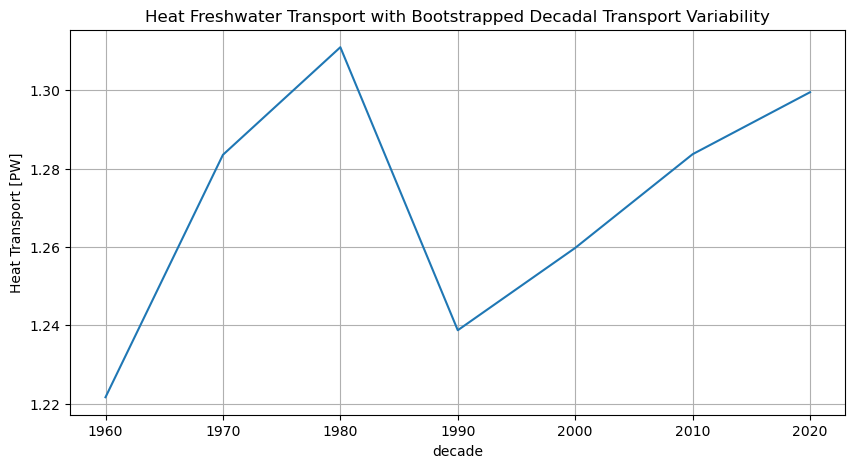

In [132]:
plt.figure(figsize=(10,5))
(heat_transport_net/(10**15)).plot()
plt.grid()
plt.ylabel('Heat Transport [PW]')
plt.title('Heat Freshwater Transport with Bootstrapped Decadal Transport Variability')

## Salt Transport

In [124]:
salt_transport_atl = decadal_mean_ds_atl.practical_salinity*simulated_decadal_mean_atl_transport.transport
salt_transport_ctf = decadal_mean_ds_ctf.practical_salinity*simulated_decadal_mean_yucatan_transport.transport
salt_transport_net = salt_transport_ctf.sum(dim='depth') + salt_transport_atl.sum(dim=['depth','longitude'])

Text(0.5, 1.0, 'Net Salt Transport with Bootstrapped Decadal Transport Variability')

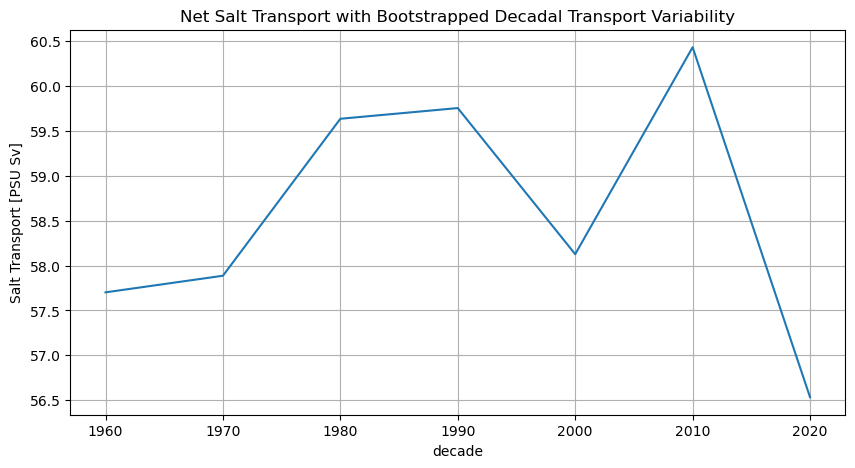

In [131]:
plt.figure(figsize=(10,5))
(salt_transport_net/(10**6)).plot()
plt.grid()
plt.ylabel('Salt Transport [PSU Sv]')
plt.title('Net Salt Transport with Bootstrapped Decadal Transport Variability')

## Freshwater Transpot

In [128]:
sbar = decadal_mean_ds_atl.practical_salinity.mean().values

freshwater_transport_atl = (-1/sbar)*((decadal_mean_ds_atl.practical_salinity*simulated_decadal_mean_atl_transport.transport)-(simulated_decadal_mean_atl_transport.transport*sbar))
freshwater_transport_ctf = (-1/sbar)*((decadal_mean_ds_ctf.practical_salinity*simulated_decadal_mean_yucatan_transport.transport)-(simulated_decadal_mean_yucatan_transport.transport*sbar))
freshwater_transport_net = freshwater_transport_ctf.sum(dim='depth') + freshwater_transport_atl.sum(dim=['depth','longitude'])

Text(0.5, 1.0, 'Net Freshwater Transport with Bootstrapped Decadal Transport Variability')

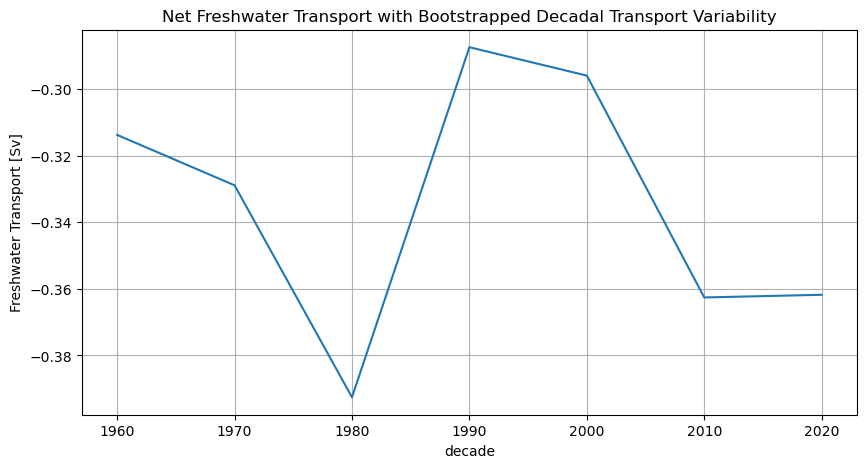

In [130]:
plt.figure(figsize=(10,5))
(freshwater_transport_net/(10**6)).plot()
plt.grid()
plt.ylabel('Freshwater Transport [Sv]')
plt.title('Net Freshwater Transport with Bootstrapped Decadal Transport Variability')